# Predictive Analysis for CP Mortality Percentage of Population by Conditions Using Random Forest Regression

In [1]:
import os
from pathlib import Path
import sys

# set working directory to the module's home
cwd = os.getcwd()
os.chdir(Path(cwd).parents[0])

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from config import connect
from db_management.database_management import load_data
from modeling.random_forest_regression import RFRegressor

### Connect to MySQL Database `AQI` for the Table `combined`

In [3]:
conn = connect()
cursor = conn.cursor()

In [4]:
df = load_data(conn, "AQI", "combined")
df.head()

,Year,State,Parameter,AQI,Age_Group,Population,CP_deaths,Total_deaths,Pct_CP_Death
0,1980,Alabama,CO,39.61,< 1 year,63503.0,76.0,962.0,7.90
1,1980,Alabama,CO,39.61,1-4 years,237138.0,18.0,185.0,9.73
2,1980,Alabama,CO,39.61,5-9 years,314150.0,8.0,113.0,7.08
3,1980,Alabama,CO,39.61,10-14 years,328096.0,6.0,125.0,4.80
4,1980,Alabama,CO,39.61,15-19 years,377406.0,29.0,370.0,7.84


### Draw a random sample from the data of size 5000

In [5]:
sample_df = df.dropna().sample(n=5000)

### Build a Random Forest Regression (RFR) model fitted on the sample data

In [6]:
rfr = RFRegressor(target='Pct_CP_Death', features=['AQI', 'Parameter', 'Age_Group'], random_seed=123)

# removed State as a feature due to concern of overfitting

rfr

In [7]:
rfr.split_and_train(sample_df)

#### Hypertune model parameters and re-train it

In [8]:
parameters = {
    "n_estimators": [500, 1000, 1500, 2000],
}
rfr.hypertune(parameters)

{'n_estimators': 2000}


#### Predict the target using the train set and the test set. Plot the results for human-eye fit confirmation

In [9]:
y_predict_train, train_score = rfr.predict_score_train()
train_score

0.9997920167387911

In [10]:
y_predict_test, test_score = rfr.predict_score_test()
test_score

0.9997900583602304

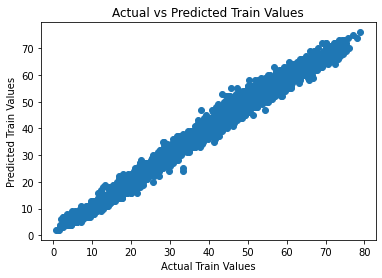

In [11]:
plt.scatter(rfr.y_train, y_predict_train)
plt.xlabel("Actual Train Values")
plt.ylabel("Predicted Train Values")
plt.title("Actual vs Predicted Train Values")
plt.show()

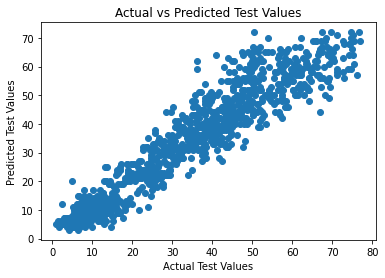

In [12]:
plt.scatter(rfr.y_test, y_predict_test)
plt.xlabel("Actual Test Values")
plt.ylabel("Predicted Test Values")
plt.title("Actual vs Predicted Test Values")
plt.show()

### Run the model on a different sample set of the data to see how it performs

In [13]:
sample_df2 = df.dropna().sample(n=1000)

In [14]:
pred_df = rfr.predict_data(sample_df2)

In [15]:
pred_df['less_than_5_pct_diff'] = 1
pred_df.loc[np.abs(pred_df['Pct_CP_Death'] - pred_df['predicted_Pct_CP_Death']) > 5, 'less_than_5_pct_diff'] = 0

pred_df.tail()

,Year,State,Parameter,AQI,Age_Group,Population,CP_deaths,Total_deaths,Pct_CP_Death,predicted_Pct_CP_Death,less_than_5_pct_diff
64779,2004,Virginia,Ozone,47.39,20-24 years,537407.0,38.0,467.0,8.0,5.0,1
5811,1982,Montana,Ozone,32.63,65-74 years,54900.0,828.0,1484.0,56.0,51.0,1
64338,2004,Pennsylvania,CO,13.33,85+ years,256487.0,23425.0,39534.0,59.0,53.0,0
32166,1992,Nevada,PM2.5,14.32,25-34 years,250308.0,35.0,327.0,11.0,12.0,1
23008,1988,Virginia,Ozone,68.69,1-4 years,344201.0,25.0,157.0,16.0,13.0,1


In [16]:
values = pred_df.less_than_5_pct_diff.value_counts()
values[1] / (values[1] + values[0])

0.732

### Plot Feature Importance

In [17]:
features = pd.DataFrame(
    {
        "field": rfr.rf_reg.feature_names_in_,
        "importance": rfr.rf_reg.feature_importances_
    }
)
features = features.set_index('field')
features

,importance
field,
AQI,0.051810
Parameter_CO,0.002826
Parameter_NO2,0.002040
Parameter_Ozone,0.001961
Parameter_PM10,0.002050
Parameter_PM2.5,0.003171
Parameter_SO2,0.001860
Age_Group_1-4 years,0.002480
Age_Group_10-14 years,0.001356


In [18]:
limited = features.sort_values("importance", ascending=False).head(10)

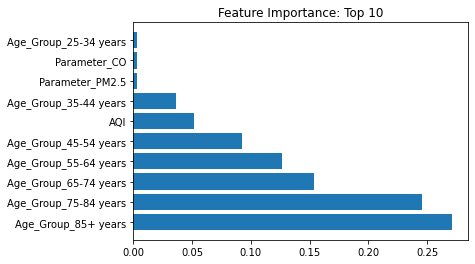

In [19]:
plt.barh(limited.index, limited.importance)
plt.title("Feature Importance: Top 10")
plt.show()